# AE370 Group Project 2 Code
**Collaborators:  Avaneesh Gokhale, Sahilkrishna Vazhathodiyil, Ayush Pathy, Benjamin Hsu, Hiko Chen**

**Date: 5/13/2025**

This notebook provides the code used in our group's AE370 Numerical Methods group project.

# Section 3.2
## Method Implementation Setup and Results Plotting

In [10]:
# Cell 1: Code Setup

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.sparse import diags, eye
from scipy.sparse.linalg import splu

# Physical beam parameters
L       = 1.0       # beam length (m)
rho     = 2700      # density (kg/m^3)
A_cross = 0.01      # cross-sectional area (m^2)
E       = 70e9      # Young's modulus (Pa)
I       = 8.33e-6   # second moment of area (m^4)
EI      = E * I

# --- exact solution / mode shape ---
def compute_lambda1(L):
    # solve for lambda * L from [4.6,4.8]
    return brentq(lambda lam: np.cos(lam)*np.cosh(lam) - 1,
                  4.6, 4.8) / L

def exact_solution(x, t):
    lam    = compute_lambda1(L)
    lamL   = lam * L
    eta    = (np.cosh(lamL) - np.cos(lamL)) \
           / (np.sinh(lamL) - np.sin(lamL))
    phi    = (np.cosh(lam * x) - np.cos(lam * x)
            - eta * (np.sinh(lam * x) - np.sin(lam * x)))
    phi   /= np.max(np.abs(phi))
    omega  = lam**2 * np.sqrt(EI / (rho * A_cross))
    return phi * np.cos(omega * t)

# --- helper to build the 4th-derivative matrix with clamped-clamped BCs ---
def construct_A(n, dx):
    data    = [np.ones(n), -4*np.ones(n), 6*np.ones(n),
               -4*np.ones(n), np.ones(n)]
    offsets = [-2, -1,  0,  1,  2]
    A = diags(data, offsets, shape=(n,n), format='lil')
    # ghost-node adjustments for BCs
    A[0, :3]     = [7, -4, 1]
    A[1, :4]     = [-4, 6, -4, 1]
    A[-2, -4:]   = [1, -4, 6, -4]
    A[-1, -3:]   = [1, -4, 7]
    return A.tocsc() / dx**4

#  Crank Nicolson solver (returns full time-history)
def crank_nicolson_beam(n, dt, T):
    dx    = L / (n + 1)
    beta2 = EI / (rho * A_cross)
    A     = construct_A(n, dx)
    M_lhs = eye(n, format='csc') + 0.25 * dt**2 * beta2 * A
    lu    = splu(M_lhs)

    x   = np.linspace(dx, L - dx, n)
    u   = exact_solution(x, 0.0)
    v   = np.zeros_like(u)
    u_hist = [u.copy()]

    steps = int(T / dt)
    betaA = beta2 * A
    for _ in range(steps):
        rhs_u = u + 0.5 * dt * v
        rhs_v = v - 0.5 * dt * (betaA.dot(u))
        v     = lu.solve(rhs_v - 0.5 * dt * (betaA.dot(rhs_u)))
        u     = rhs_u + 0.5 * dt * v
        u_hist.append(u.copy())

    return x, np.array(u_hist)

# --- plotting helper for solution vs. exact ---
def plot_solution(x, u_hist, T):
    times   = np.linspace(0, T, u_hist.shape[0])
    indices = [0, u_hist.shape[0]//4, u_hist.shape[0]//2, -1]
    colors  = plt.cm.viridis(np.linspace(0, 1, len(indices)))

    plt.figure(figsize=(9,5))
    for idx, c in zip(indices, colors):
        t = times[idx]
        plt.plot(x, u_hist[idx], '--', lw=2.5, color=c,
                 label=f'Num @ t={t:.2e}')
        plt.plot(x, exact_solution(x, t), '-', lw=1.5, color=c,
                 label=f'Exact @ t={t:.2e}')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('Exact vs. Numerical Solution (Clamped-Clamped Beam)')
    plt.legend()
    plt.grid(True, ls='--')
    plt.tight_layout()
    plt.show()

# --- class for spatial convergence test ---
class ClampedBeam:
    def __init__(self, L, E, I, rho, A_cross, n, dt):
        self.L, self.EI = L, E * I
        self.beta2     = self.EI / (rho * A_cross)
        self.n, self.dt = n, dt
        self.dx        = L / (n + 1)
        self.x         = np.linspace(self.dx, L - self.dx, n)

        lamL           = brentq(lambda lam: np.cos(lam)*np.cosh(lam) - 1,
                                 4.6, 4.8)
        self.lambda1   = lamL / L
        eta            = ((np.cosh(lamL) - np.cos(lamL))
                       / (np.sinh(lamL) - np.sin(lamL)))
        phi              = ((np.cosh(self.lambda1 * self.x)
                       - np.cos(self.lambda1 * self.x))
                       - eta * (np.sinh(self.lambda1 * self.x)
                       - np.sin(self.lambda1 * self.x)))
        self.phi       = phi / np.max(np.abs(phi))
        self.omega     = self.lambda1**2 * np.sqrt(self.EI / (rho * A_cross))

        # build and factor M = I + 0.25 dt^2 beta2 A
        A_mat = construct_A(n, self.dx)
        M_mat = eye(n, format='csc') + 0.25 * (self.dt**2) * self.beta2 * A_mat
        self.lu = splu(M_mat)
        self.A  = A_mat

    def exact(self, t):
        return self.phi * np.cos(self.omega * t)

    def final_deflection(self, T):
        u     = self.phi.copy()
        v     = np.zeros_like(u)
        steps = int(T / self.dt)
        betaA    = self.beta2 * self.A
        for _ in range(steps):
            rhs_u = u + 0.5 * self.dt * v
            rhs_v = v - 0.5 * self.dt * (betaA.dot(u))
            v     = self.lu.solve(rhs_v
                     - 0.5 * self.dt * (betaA.dot(rhs_u)))
            u     = rhs_u + 0.5 * self.dt * v
        return u 

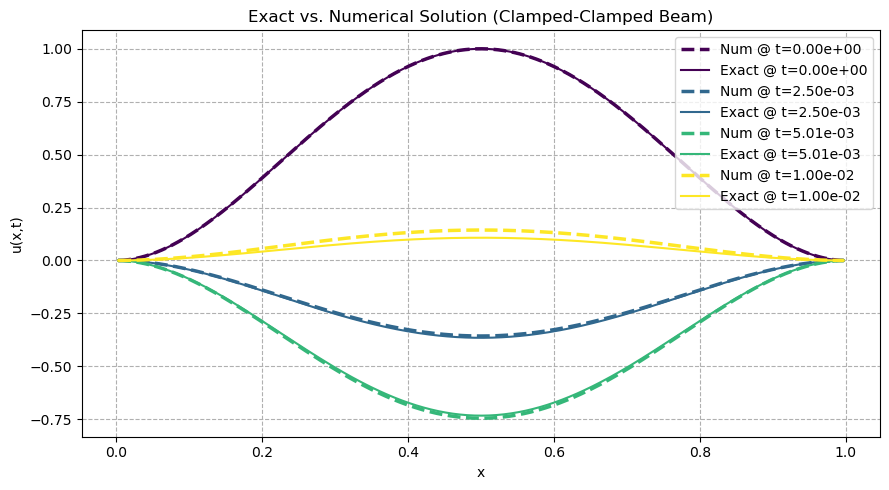

In [11]:
#  Cell 2: Exact vs. Numerical 
n_plot  = 400           # moderate mesh
dt_plot = 1e-5          # timestep
T_plot  = 0.01          # final time

x, u_hist = crank_nicolson_beam(n_plot, dt_plot, T_plot)
plot_solution(x, u_hist, T_plot)

# Section 3.3
## Spatial Convergence Study

<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ushni\AppData\Local\Temp\ipykernel_35072\3093359168.py:17: SyntaxWarning: invalid escape sequence '\D'
  'k--', label='O($\Delta x^2$)')


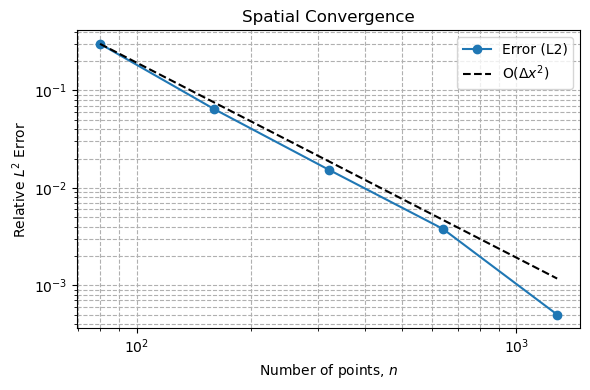

In [5]:
#  Cell 3: Spatial Convergence 
ns       = [80, 160, 320, 640, 1280]
T_final  = 0.01
errors   = []

for n in ns:
    dx  = L/(n+1)
    dt  = 0.1*dx**2
    beam = ClampedBeam(L, E, I, rho, A_cross, n, dt)
    u_n  = beam.final_deflection(T_final)
    u_e  = beam.exact(T_final)
    errors.append(np.linalg.norm(u_n - u_e) / np.linalg.norm(u_e))

plt.figure(figsize=(6,4))
plt.loglog(ns, errors, 'o-', label='Error (L2)')
plt.loglog(ns, [errors[0]*(ns[0]/n)**2 for n in ns],
    'k--', label='O($\Delta x^2$)')
plt.xlabel('Number of points, $n$')
plt.ylabel('Relative $L^2$ Error')
plt.title('Spatial Convergence')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

# Section 3.4
## Temporal Convergence Study

<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ushni\AppData\Local\Temp\ipykernel_35072\1917701675.py:28: SyntaxWarning: invalid escape sequence '\D'
  plt.loglog(dts,     ref_line,  '--', label='O($\Delta t^2$)')
C:\Users\ushni\AppData\Local\Temp\ipykernel_35072\1917701675.py:29: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta t$')


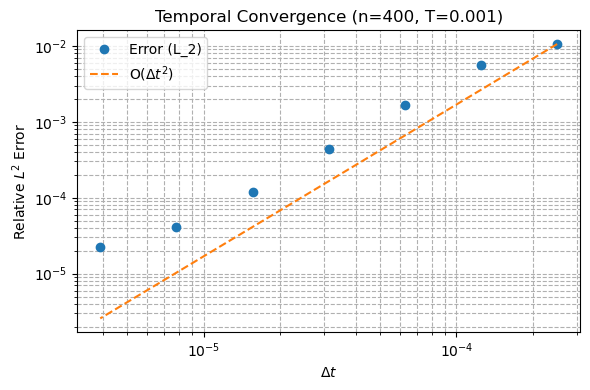

In [12]:
# Cell 4: Temporal convergence with a very fine mesh
import numpy as np
import matplotlib.pyplot as plt

# 1) Fix spatial mesh so spatial error is much larger than temporal error
n   = 400       # very fine grid
T   = 0.001     # short final time to avoid dispersion

# 2) Define time-step sequence so that T/\Deltat is integer
Ns  = 2**np.arange(2,9)    # N = [4,8,16,32,64,128,256]
dts = T / Ns

errors = []
for dt in dts:
    x, u_hist = crank_nicolson_beam(n, dt, T)
    u_num     = u_hist[-1]
    u_exact   = exact_solution(x, T)
    errors.append(np.linalg.norm(u_num - u_exact)
                  / np.linalg.norm(u_exact))
errors = np.array(errors)

# reference O(\Delta t^2) line
ref_line = errors[0] * (dts / dts[0])**2

# plot
plt.figure(figsize=(6,4))
plt.loglog(dts,     errors,    'o', label='Error (L_2)')
plt.loglog(dts,     ref_line,  '--', label='O($\Delta t^2$)')
plt.xlabel('$\Delta t$')
plt.ylabel('Relative $L^2$ Error')
plt.title('Temporal Convergence (n=400, T=0.001)')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

# Section 4
## Q1: Effect of Boundary Conditions on Frequencies and Mode Shapes

<>:72: SyntaxWarning: invalid escape sequence '\l'
<>:84: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\l'
<>:84: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ushni\AppData\Local\Temp\ipykernel_35072\2997800829.py:72: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\lambda_i L$')
C:\Users\ushni\AppData\Local\Temp\ipykernel_35072\2997800829.py:84: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('x'); plt.ylabel('$\phi_i(x)$')


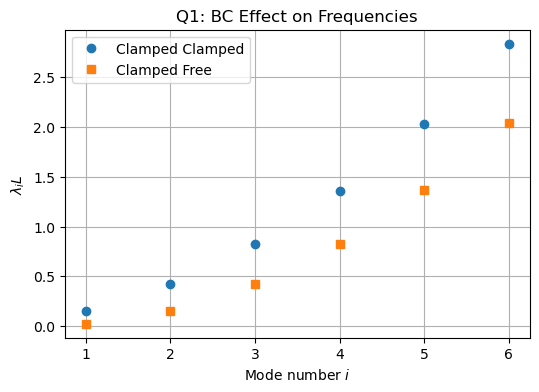

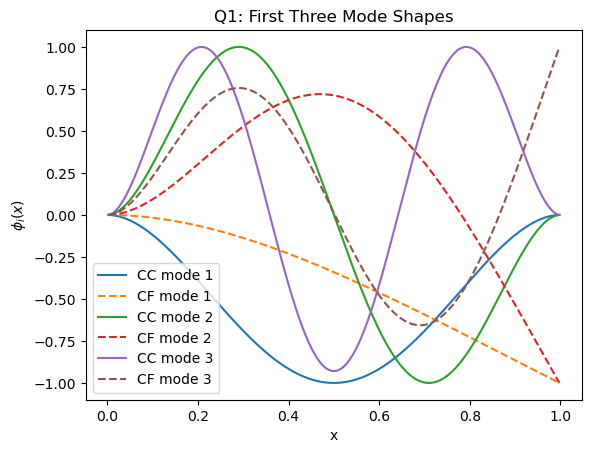

In [14]:
import warnings
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigs, splu
from scipy.sparse import eye

# 1) Method for computing eigenmodes
def compute_eigenmodes(bc, n, num_modes=6):
    """
    Computes the first `num_modes` eigenpairs of
      A φ = (λ^2 β^2) φ
    under boundary condition `bc`.
    Returns (lambda_vals, mode_shapes), where
    lambda_vals = np.sqrt(eigvals)/β
    """
    dx    = L/(n+1)
    A     = construct_A_bc(n, dx, bc=bc)
    beta2 = EI/(rho*A_cross)
    # generalized eigenproblem A φ = μ φ, with μ = λ^2 β^2
    μ, Φ = eigs(A, k=num_modes, sigma=0, which='LM')  
    # sort real positive
    idx = np.argsort(np.real(μ))
    μ   = np.real(μ[idx])
    Φ   = np.real(Φ[:, idx])
    λ   = np.sqrt(μ/beta2)
    return λ, Φ

# 2) Fixed construct_A_bc for CF
def construct_A_bc(n, dx, bc='CC'):
    """
    Assemble the n×n 4th‑derivative matrix with either
    'CC' = clamped–clamped or 'CF' = clamped–free BCs.
    """
    offsets = [-2, -1, 0, 1, 2]
    data    = [ np.ones(n), -4*np.ones(n), 6*np.ones(n),
               -4*np.ones(n),  np.ones(n) ]
    A = diags(data, offsets, shape=(n,n), format='lil')

    # clamped at x=0 (identical for both CC/CF)
    A[0, :3] = [7, -4, 1]
    A[1, :4] = [-4, 6, -4, 1]

    if bc == 'CC':
        # clamped at x=L
        A[-2, -4:] = [1, -4, 6, -4]
        A[-1, -3:] = [1, -4, 7]

    elif bc == 'CF':
        # free at x=L: enforce u''=0 and u'''=0
        # second‑to‑last row (i=n-1 → index n-2)
        A[n-2, n-4:n] = [1, -4, 5, -2]
        # last row (i=n → index n-1)
        A[n-1, n-3:n] = [3, -6, 3]

    else:
        raise ValueError("bc must be 'CC' or 'CF'")

    return A.tocsc() / dx**4

# compute first six modes for CC and CF
lambda_CC, Phi_CC = compute_eigenmodes('CC', n=400, num_modes=6)
lambda_CF, Phi_CF = compute_eigenmodes('CF', n=400, num_modes=6)

# nondimensionalize and plot
nd_CC = lambda_CC * L
nd_CF = lambda_CF * L
modes = np.arange(1,7)

plt.figure(figsize=(6,4))
plt.plot(modes, nd_CC, 'o', label='Clamped Clamped')
plt.plot(modes, nd_CF, 's', label='Clamped Free')
plt.xlabel('Mode number $i$')
plt.ylabel('$\lambda_i L$')
plt.title('Q1: BC Effect on Frequencies')
plt.legend()
plt.grid(True)
plt.show()

x = np.linspace(L/(401), L-L/401, 400)
for i in [0,1,2]:
    plt.plot(x, Phi_CC[:,i]/np.max(np.abs(Phi_CC[:,i])),
             label=f'CC mode {i+1}')
    plt.plot(x, Phi_CF[:,i]/np.max(np.abs(Phi_CF[:,i])),
             '--', label=f'CF mode {i+1}')
plt.xlabel('x'); plt.ylabel('$\phi_i(x)$')
plt.title('Q1: First Three Mode Shapes'); plt.legend(); plt.show()

Q2 : 

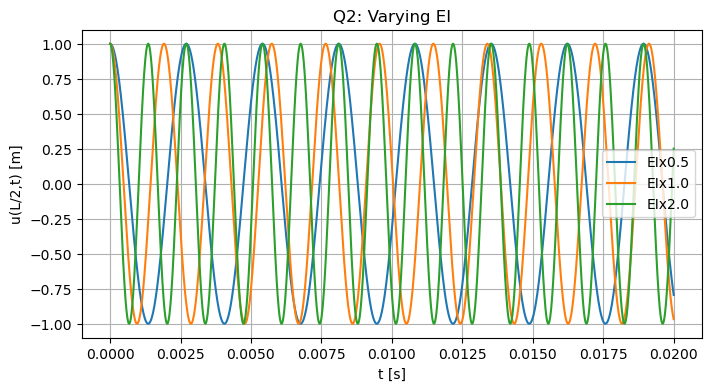

) missing from font(s) DejaVu Sans.ackages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


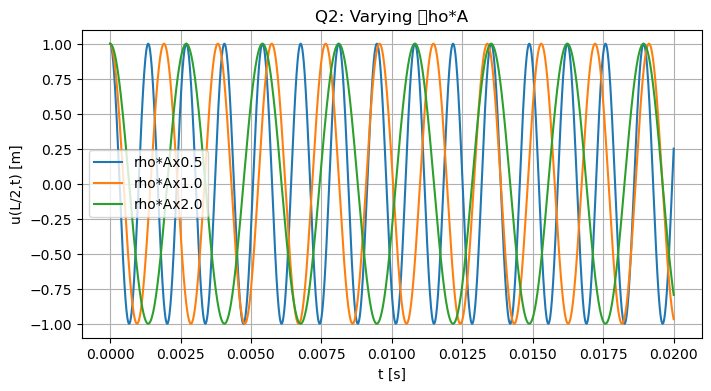

In [15]:
def sweep_transient(EI_factors, rhoA_factors, n=400, dt=1e-5, T=0.02):
    """
    Returns a dict mapping (f_EI, f_rhoA) -> (t array, u_mid array),
    correctly using the scaled parameters in the time-march.
    """
    results = {}
    mid_idx = n // 2
    # spatial grid spacing
    dx = L/(n+1)

    for f_e in EI_factors:
        for f_r in rhoA_factors:
            # locally scale stiffness and mass
            E_mod   = E * f_e
            rho_mod = rho * f_r

            # build a beam object with these scaled values
            beam = ClampedBeam(L, E_mod, I, rho_mod, A_cross, n, dt)

            # march in time using the beam's own LU factorization
            u = beam.phi.copy()
            v = np.zeros_like(u)
            u_hist = [u.copy()]
            betaA = beam.beta2 * beam.A

            steps = int(T/dt)
            for _ in range(steps):
                rhs_u = u + 0.5*dt*v
                rhs_v = v - 0.5*dt*(betaA.dot(u))
                v     = beam.lu.solve(rhs_v - 0.5*dt*(betaA.dot(rhs_u)))
                u     = rhs_u + 0.5*dt*v
                u_hist.append(u.copy())

            # build matching time vector
            t = np.linspace(0, T, len(u_hist))

            # record mid-span deflection history
            results[(f_e, f_r)] = (t, np.array(u_hist)[:, mid_idx])

    return results

# perform the corrected sweep
factors_EI   = [0.5, 1.0, 2.0]
factors_rhoA = [0.5, 1.0, 2.0]
results = sweep_transient(factors_EI, factors_rhoA, n=400, dt=1e-5, T=0.02)

# plot EI-variation
plt.figure(figsize=(8,4))
for f_e in factors_EI:
    t, u = results[(f_e, 1.0)]
    plt.plot(t, u, label=f'EIx{f_e}')
plt.xlabel('t [s]')
plt.ylabel('u(L/2,t) [m]')
plt.title('Q2: Varying EI')
plt.legend()
plt.grid(True)
plt.show()

# plot rhoA-variation
plt.figure(figsize=(8,4))
for f_r in factors_rhoA:
    t, u = results[(1.0, f_r)]
    plt.plot(t, u, label=f'rho*Ax{f_r}')
plt.xlabel('t [s]')
plt.ylabel('u(L/2,t) [m]')
plt.title('Q2: Varying \rho*A')
plt.legend()
plt.grid(True)
plt.show()

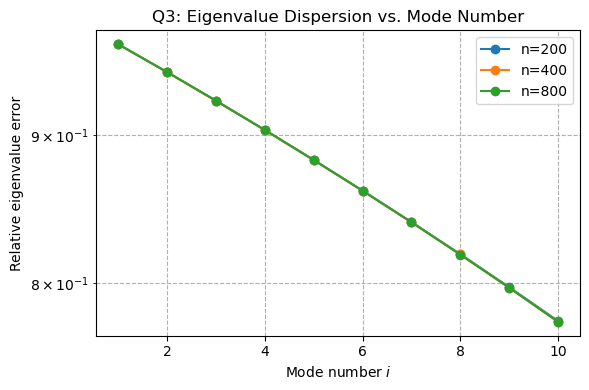

In [18]:
# Eigenvalue Error vs. Mode Number
def eigenmode_errors(n_list, num_modes=10):
    """
    For each mesh in n_list, compute first `num_modes` λ_i (num) and λ_i (exact),
    return dict: errors[n] = (i_array, rel_error_array)
    """
    # analytic λ_i: solve cos(lamL)cosh(lamL)=1 for lamL ≈ (i+0.5)*π
    lamL_exact = []
    for i in range(1, num_modes+1):
        b0 = (i+0.4)*np.pi
        b1 = (i+0.6)*np.pi
        lamL_exact.append(brentq(lambda m: np.cos(m)*np.cosh(m)-1, b0, b1))
    lam_exact = np.array(lamL_exact)/L

    errors = {}
    for n in n_list:
        λ_num, _ = compute_eigenmodes('CC', n, num_modes)
        rel_err   = np.abs(λ_num - lam_exact)/lam_exact
        errors[n] = (np.arange(1, num_modes+1), rel_err)
    return errors

# Compute relative eigenvalue errors for first 10 modes on meshes n = 200, 400, 800
errors = eigenmode_errors([200, 400, 800], num_modes=10)

# Plot relative error vs. mode number on a log scale
plt.figure(figsize=(6,4))
for n in [200, 400, 800]:
    modes, rel_err = errors[n]
    plt.plot(modes, rel_err, 'o-', label=f'n={n}')
plt.yscale('log')
plt.xlabel('Mode number $i$')
plt.ylabel('Relative eigenvalue error')
plt.title('Q3: Eigenvalue Dispersion vs. Mode Number')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

<>:74: SyntaxWarning: invalid escape sequence '\D'
<>:75: SyntaxWarning: invalid escape sequence '\m'
<>:74: SyntaxWarning: invalid escape sequence '\D'
<>:75: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ushni\AppData\Local\Temp\ipykernel_35072\2451531605.py:74: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('\Delta t [s]')
C:\Users\ushni\AppData\Local\Temp\ipykernel_35072\2451531605.py:75: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Amplification |\mu|')


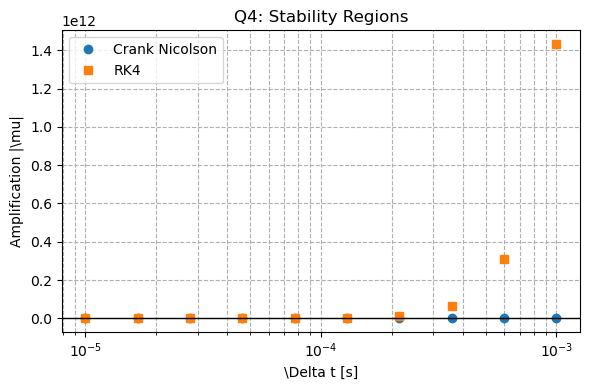

In [20]:
# Stability Comparison: CN vs. RK4
def step_RK4(u, v, dt, betaA):
    """
    Single RK4 step for ü = -beta2*A u
    state y=[u;v], y'=[v; -beta2*A u]
    """
    def f(y):
        u_, v_ = y[:len(u)], y[len(u):]
        return np.concatenate([v_, -betaA.dot(u_)])
    y0 = np.concatenate([u, v])
    k1 = f(y0)
    k2 = f(y0 + 0.5*dt*k1)
    k3 = f(y0 + 0.5*dt*k2)
    k4 = f(y0 +     dt*k3)
    y1 = y0 + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    return y1[:len(u)], y1[len(u):]


from scipy.sparse import SparseEfficiencyWarning
import warnings
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

def test_stability(dt_list, n=200):
    """
    For each dt, take one step with CN and one with RK4,
    return amplification factors for both schemes.
    """
    dx    = L/(n+1)
    beta2 = EI/(rho*A_cross)
    A_mat = construct_A_bc(n, dx, 'CC')

    # pre build identity in CSC format
    I_n = eye(n, format='csc')

    amp_CN  = []
    amp_RK4 = []

    # initial state
    x   = np.linspace(dx, L-dx, n)
    u0  = exact_solution(x, 0.0)
    v0  = np.zeros_like(u0)

    for dt in dt_list:
        # Crank Nicolson one step
        lhs = I_n + 0.25*dt**2 * beta2 * A_mat
        lhs = lhs.tocsc()           # ensure CSC before factorization
        lu  = splu(lhs)
        rhs = u0 + 0.5*dt*v0
        v1  = lu.solve(v0 - 0.5*dt*beta2*(A_mat.dot(u0)))
        u1  = rhs + 0.5*dt*v1
        amp_CN.append(
            np.linalg.norm(np.hstack([u1, v1])) /
            np.linalg.norm(np.hstack([u0, v0]))
        )

        # RK4 one step
        u_rk, v_rk = step_RK4(u0, v0, dt, beta2 * A_mat)
        amp_RK4.append(
            np.linalg.norm(np.hstack([u_rk, v_rk])) /
            np.linalg.norm(np.hstack([u0, v0]))
        )

    return np.array(amp_CN), np.array(amp_RK4)

# run stability test
dts = np.logspace(-5, -3, 10)
amp_CN, amp_RK4 = test_stability(dts, n=200)

# plot amplification factors
plt.figure(figsize=(6,4))
plt.plot(dts, amp_CN, 'o', label='Crank Nicolson')
plt.plot(dts, amp_RK4, 's', label='RK4')
plt.xscale('log')
plt.xlabel('\Delta t [s]')
plt.ylabel('Amplification |\mu|')
plt.axhline(1.0, color='k', lw=1)
plt.title('Q4: Stability Regions')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

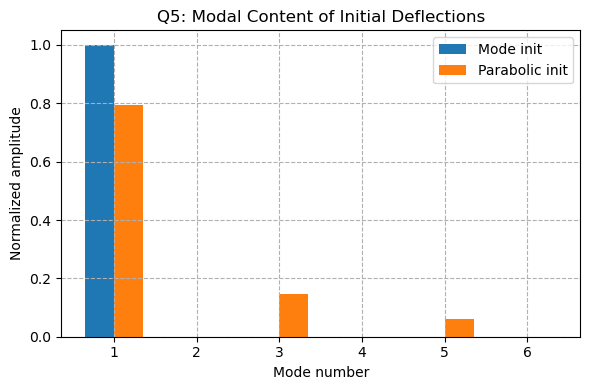

In [22]:
# Modal Decomposition of Initial Conditions
def modal_decomposition(u0, Φ, dx):
    """
    Project u0 onto the columns of Φ under the discrete L2 inner product.
    Returns a vector of modal amplitudes a_i.
    """
    a = Φ.T.dot(u0)*dx   # assuming modes are orthonormal under dx‐weighted L2
    return a / np.sum(np.abs(a))
# Compute first six CC modes on a fine mesh
lambda_vals, Phi = compute_eigenmodes('CC', 400, num_modes=6)
dx = L/(400+1)
x  = np.linspace(dx, L-dx, 400)

# Define two initial deflections
u_mode    = Phi[:,0]         # pure first mode shape
u_parab   = x * (L - x)      # parabolic profile

# Project each initial shape onto the discrete eigenbasis
a_mode    = modal_decomposition(u_mode,  Phi, dx)
a_parab   = modal_decomposition(u_parab, Phi, dx)

# Plot normalized modal amplitudes for modes 1 through 6
indices = np.arange(1,7)
width   = 0.35
plt.figure(figsize=(6,4))
plt.bar(indices - width/2, np.abs(a_mode),  width, label='Mode init')
plt.bar(indices + width/2, np.abs(a_parab), width, label='Parabolic init')
plt.xlabel('Mode number')
plt.ylabel('Normalized amplitude')
plt.title('Q5: Modal Content of Initial Deflections')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()